# Covid-19 detection using a CNN

### 1. Packages

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os

In [40]:
# Rename files (once done, not needed)

paths = ["./Dataset/0_Training/Covid", "./Dataset/0_Training/NotCovid", "./Dataset/1_Test/Covid", "./Dataset/1_Test/NotCovid"]

# for path in paths:
#     for i,f in enumerate(os.listdir(path)):
#         # print (i, f)
#         os.rename (path+"/"+f, path+"/"+str(i)+os.path.splitext(f)[1])

### 2. CNN Model using the Sequential API
<ul>
<li>Since we have a single input & output scheme (linear topology), the Sequential API suffices</li>
</ul>

In [22]:
model = Sequential()

model.add (Conv2D (32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add (Conv2D (64, (3,3), activation='relu'))
model.add (MaxPooling2D (pool_size=(2,2)))          # max pool
model.add (Dropout (0.25))                          # dropout regularization (prevents overfitting)

model.add (Conv2D (64, (3,3), activation='relu'))
model.add (MaxPooling2D (pool_size=(2,2)))
model.add (Dropout (0.25))

model.add (Conv2D (128, (3,3), activation='relu'))
model.add (MaxPooling2D (pool_size=(2,2)))
model.add (Dropout (0.25))

model.add (Flatten())
model.add (Dense (64, activation='relu'))
model.add (Dropout (0.5))
model.add (Dense (1, activation='sigmoid'))

# metric used is "accuracy" (of prediction on the datasets)
# "binary" crossentropy, as we have 2 classes
model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

### 3. Train

In [24]:
# horizontal flip -- data augmentation applied to the training data
train_genr = image.ImageDataGenerator (rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_genr = image.ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_genr.flow_from_directory ('./Dataset/0_Training', target_size = (224,224), batch_size = 32, class_mode = 'binary')
train_generator.class_indices

Found 224 images belonging to 2 classes.


{'Covid': 0, 'NotCovid': 1}

In [28]:
test_generator = test_genr.flow_from_directory ('./Dataset/1_Test', target_size = (224,224), batch_size = 32, class_mode = 'binary')
test_generator.class_indices

Found 60 images belonging to 2 classes.


{'Covid': 0, 'NotCovid': 1}

In [32]:
# fit_generator used in case entire data can't fit inside RAM, or when data has been augmented
history = model.fit (train_generator, steps_per_epoch=5, epochs = 10, validation_data = test_generator, validation_steps=2)

Epoch 1/10
5/5 [==============================] - 26s 5s/step - loss: 0.4343 - accuracy: 0.8313 - val_loss: 0.2937 - val_accuracy: 0.9333
Epoch 2/10
5/5 [==============================] - 23s 5s/step - loss: 0.2705 - accuracy: 0.8813 - val_loss: 0.2413 - val_accuracy: 0.9667
Epoch 3/10
5/5 [==============================] - 26s 5s/step - loss: 0.2650 - accuracy: 0.9062 - val_loss: 0.1511 - val_accuracy: 0.9500
Epoch 4/10
5/5 [==============================] - 27s 5s/step - loss: 0.2185 - accuracy: 0.9062 - val_loss: 0.2203 - val_accuracy: 0.9667
Epoch 5/10
5/5 [==============================] - 24s 4s/step - loss: 0.2651 - accuracy: 0.9125 - val_loss: 0.1479 - val_accuracy: 0.9833
Epoch 6/10
5/5 [==============================] - 28s 5s/step - loss: 0.1892 - accuracy: 0.9375 - val_loss: 0.1095 - val_accuracy: 0.9833
Epoch 7/10
5/5 [==============================] - 32s 6s/step - loss: 0.1022 - accuracy: 0.9500 - val_loss: 0.0722 - val_accuracy: 0.9667
Epoch 8/10
5/5 [==================

In [33]:
model.save('model_cnn.h5')

In [36]:
model.evaluate(train_generator)

7/7 [==============================] - 15s 2s/step - loss: 0.0920 - accuracy: 0.9643


[0.09199760109186172, 0.9642857313156128]

In [37]:
model.evaluate(test_generator)

2/2 [==============================] - 4s 2s/step - loss: 0.0451 - accuracy: 0.9833


[0.04513062536716461, 0.9833333492279053]

### 4. Test

In [80]:
myModel = load_model ('model_cnn.h5')

In [87]:
y_actual = []
y_test = []

for i in os.listdir(paths[3]):                  # "./Dataset/1_Test/NotCovid/"
    img = image.load_img (paths[3]+"/"+i, target_size=(224,224))
    img = image.img_to_array (img)
    img = np.expand_dims (img, axis=0)
    y_pred = np.round(myModel.predict(img)).astype(int)
    y_test.append (y_pred[0,0])
    y_actual.append (1)                         # 'actual' is '1', i.e. 'NotCovid'

for i in os.listdir(paths[2]):                  # "./Dataset/1_Test/Covid/"
    img = image.load_img(paths[2]+"/"+i, target_size=(224,224))
    img = image.img_to_array (img)
    img = np.expand_dims (img, axis=0)
    y_pred = np.round(myModel.predict(img)).astype(int)
    y_test.append (y_pred[0,0])
    y_actual.append(0)                          # 'actual' is '0', i.e. 'Covid'

total = len(y_test)
wrong = 0
for i in range(total):
    if (y_test[i] != y_actual[i]):
        wrong += 1
print('Total: ', total, '\tWrong: ', wrong)

Total:  60 	Wrong:  2


### 5. Confusion Matrix

<table>
    <tr>
        <td style="padding:30px;">True Positives</td>
        <td style="padding:30px;">False Negatives</td>
    </tr>
    <tr>
        <td style="padding:30px;">False Positives</td>
        <td style="padding:30px;">True Negatives</td>
    </tr>
</table>

<ul>
    <li>True Positives (Negatives) : Actual positive (negative), and predicted positive (negative)
    <li>False Positives (Negatives) : Actual negative (positive), but predicted positive (negative)
</ul>

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 1.0, 'Confusion Matrix\n')

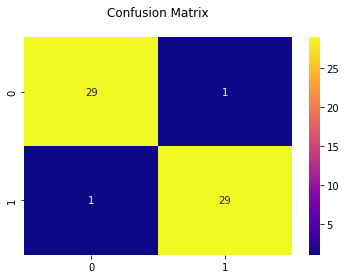

In [85]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)
conf_mat = confusion_matrix (y_actual, y_test)
ax = sns.heatmap (conf_mat, cmap='plasma', annot=True)
ax.set_title ("Confusion Matrix\n")

### 6. Custom Test Image

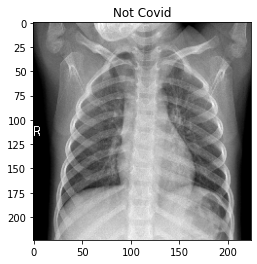

In [97]:
filepath = './test_image.jpeg'                          # put the test image's path, name, and extension
img = image.load_img (filepath, target_size=(224,224))
plt.imshow(img)
img = image.img_to_array (img)
img = np.expand_dims (img, axis=0)
y_pred = np.round(myModel.predict(img)).astype(int)[0,0]
if y_pred==0:
    plt.title("Covid")
else:
    plt.title("Not Covid")